In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

<h2> Data Loading </h2> <br>
<i> Initially we define a function that loads and resizes to 150 x 150 pixels every image for every
    subset. Since the images are variable in size, a resizing is deemed necessary and for complexity
    purposes, we have decided to opt for the aforementioned resolution.
</i>

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150 

def get_data(data_dir):
    data = [] 
    img_avg_pixels = 0
    img_cnt = 0
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return [np.array(data), img_avg_pixels]

In [5]:
train = get_data('datasets/archive/chest_xray/chest_xray/train')
test = get_data('datasets/archive/chest_xray/chest_xray/test')
val = get_data('datasets/archive/chest_xray/chest_xray/val')

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-4-d9947cb972d5>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return [np.array(data), img_avg_pixels]


OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<h2> Data Preprocessing </h2> <br>
<i> After loading the resized images, we create our training, testing and validataion datasets along with
    their respective labels. <br></i>
    <b>Pneumonia => 1</b><br>
    <b>Normal => 0</b><br>


In [6]:
train = train[0]
test = test[0]
val = val[0]

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
# NORMALIZE IMAGE PIXELS
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# RESIZE DATA FOR DEEP LEARNING
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


<h2> Image augmentation </h2><br>
<i> Create an image generator which will create a balanced batch size during each
    Neural Network epoch. The images generated will differ slightly, in order to prevent
    overfitting, with the usage of techniques like image flipping, zooming and rotating.</i>

In [8]:
datagen = ImageDataGenerator(
        rotation_range = 30,  # randomly rotate image. val = Degree range for random rotations.
        zoom_range = 0.2, # Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True)  # randomly flip images

datagen.fit(x_train)

<h2> Model Layers </h2>
<b>1) Conv2D</b> <br>
    <i>This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. </i><br>
<b>2) MaxPool2D</b> <br> 
<i>Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension. </i><br>
<b>3) Dropout</b> <br>
<i>The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. </i><br>
<b>4) Flatten</b> <br>
<i>Flattens the input. Does not affect the batch size. <br> E.g. (1, 10, 64) => (640)  </i><br>
<b>5) Dense</b> <br>
<i>Just your regular densely-connected NN layer. </i><br>

In [9]:
epochs = 10

model = Sequential()

model.add(Conv2D(32 , (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32 , (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32 , (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
display(model.summary())
model_var = model.fit(datagen.flow(x_train,y_train, batch_size = 32), epochs=epochs, validation_data = datagen.flow(x_val, y_val) )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 32)        9

None

Epoch 1/12
163/163 [==============================] - 99s 602ms/step - loss: 2.7479 - accuracy: 0.8161 - val_loss: 2.5631 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 97s 593ms/step - loss: 0.7565 - accuracy: 0.8827 - val_loss: 1.4988 - val_accuracy: 0.5625
Epoch 3/12
163/163 [==============================] - 94s 579ms/step - loss: 0.2856 - accuracy: 0.9199 - val_loss: 4.4400 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 93s 573ms/step - loss: 0.1843 - accuracy: 0.9272 - val_loss: 1.7224 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 94s 575ms/step - loss: 0.1589 - accuracy: 0.9369 - val_loss: 0.9819 - val_accuracy: 0.6250
Epoch 6/12
163/163 [==============================] - 93s 571ms/step - loss: 0.1616 - accuracy: 0.9379 - val_loss: 0.6712 - val_accuracy: 0.6875
Epoch 7/12
163/163 [==============================] - 94s 574ms/step - loss: 0.1515 - accuracy: 0.9438 - val_loss: 2.5362 - val_ac

In [10]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 208ms/step - loss: 1.0324 - accuracy: 0.5529
Loss of the model is -  1.0323818922042847
20/20 [==============================] - 4s 210ms/step - loss: 1.0324 - accuracy: 0.5529
Accuracy of the model is -  55.288463830947876 %


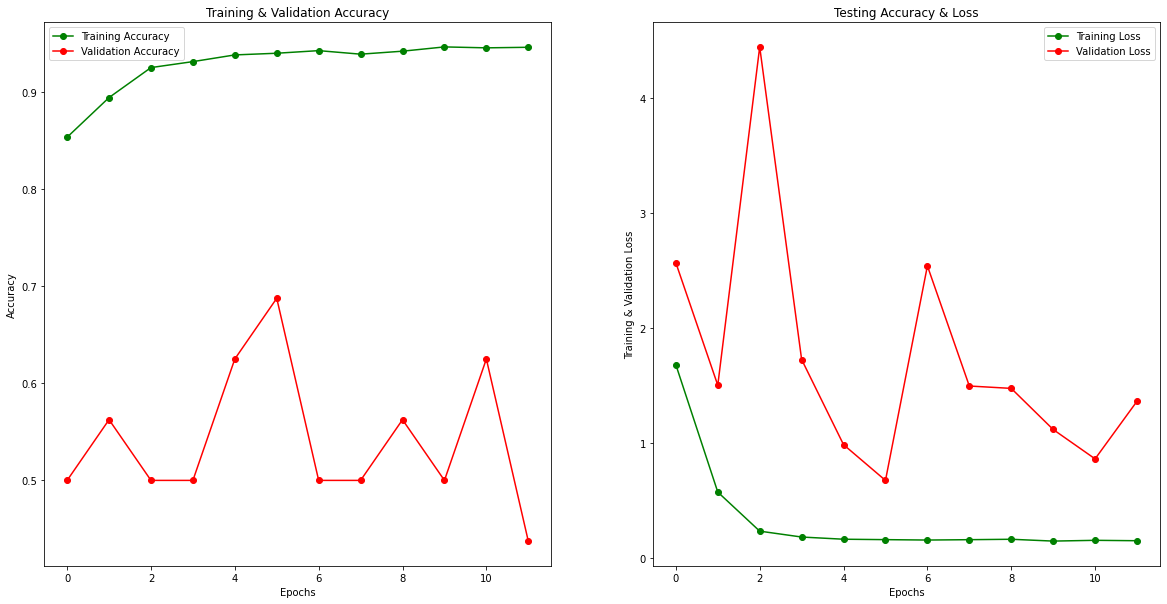

In [11]:
epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = model_var.history['accuracy']
train_loss = model_var.history['loss']
val_acc = model_var.history['val_accuracy']
val_loss = model_var.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [12]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

/mnt/c/Users/legen/Desktop/MSC/Deep Learning/Projects/Project 1/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.29      0.45       390
   Normal (Class 1)       0.46      0.98      0.62       234

           accuracy                           0.55       624
          macro avg       0.71      0.64      0.54       624
       weighted avg       0.77      0.55      0.52       624



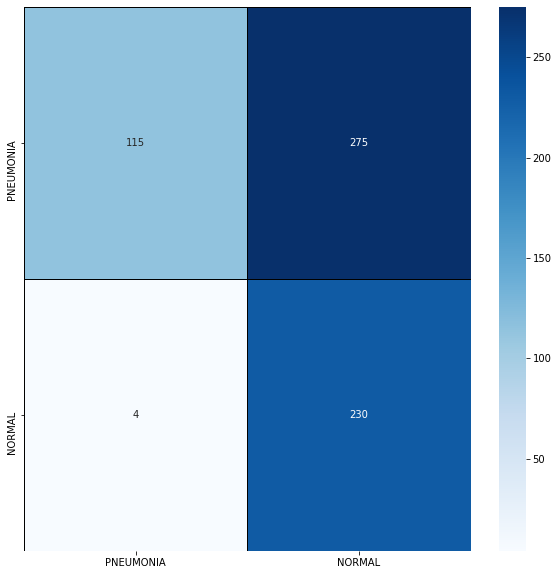

In [13]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.show()